In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

if "cuda" in device.type:
    torch.backends.cudnn.benchmark = True
    print("CuDNN optimizations: Enabled")

BATCH_SIZE = 32

CuDNN optimizations: Enabled


In [21]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)  # (이미지 수, 너비, 높이, 채널)
        self.labels = np.load(labels_path)  # (이미지 수, 너비, 높이, 1)

        # Normalize images to [0, 1] range
        self.images = self.images / 255.0

        # Swap axes to match PyTorch format: (이미지 수, 채널, 너비, 높이)
        self.images = np.transpose(self.images, (0, 3, 1, 2))

        # Convert labels to integer type
        self.labels = self.labels.astype(np.int64)

        # One-hot encode labels to match the number of classes
        num_classes = 4  # 예시로 설정한 클래스 수
        self.labels = np.eye(num_classes)[self.labels.reshape(-1)]  # (이미지 수 * 너비 * 높이, num_classes) 형태로 변환
        self.labels = self.labels.reshape(-1, self.images.shape[2], self.images.shape[3], num_classes)  # 원래 형태로 복원
        self.labels = np.transpose(self.labels, (0, 3, 1, 2))  # (이미지 수, num_classes, 너비, 높이)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)  # 원핫인코딩된 레이블 데이터

        return image, label


In [28]:
# 데이터셋 경로
base_path = '../dataset/basedata'
train_images_path = os.path.join(base_path, 'train_images.npy')
train_labels_path = os.path.join(base_path, 'train_labels.npy')
val_images_path = os.path.join(base_path, 'val_images.npy')
val_labels_path = os.path.join(base_path, 'val_labels.npy')
test_images_path = os.path.join(base_path, 'test_images.npy')
test_labels_path = os.path.join(base_path, 'test_labels.npy')

# 데이터셋 및 데이터 로더 생성
train_dataset = NumpyDataset(train_images_path, train_labels_path)
val_dataset = NumpyDataset(val_images_path, val_labels_path)
test_dataset = NumpyDataset(test_images_path, test_labels_path)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [34]:
import torch

# 데이터셋에서 첫 번째 배치 가져오기
train_iter = iter(train_loader)
images, labels = next(train_iter)

val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)

test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Shape 출력
print(f"Train dataset - Batch of images shape: {images.shape}, Batch of labels shape: {labels.shape}")
print(f"Validation dataset - Batch of images shape: {val_images.shape}, Batch of labels shape: {val_labels.shape}")
print(f"Test dataset - Batch of images shape: {test_images.shape}, Batch of labels shape: {test_labels.shape}")

Train dataset - Batch of images shape: torch.Size([128, 4, 240, 240]), Batch of labels shape: torch.Size([128, 4, 240, 240])
Validation dataset - Batch of images shape: torch.Size([128, 4, 240, 240]), Batch of labels shape: torch.Size([128, 4, 240, 240])
Test dataset - Batch of images shape: torch.Size([128, 4, 240, 240]), Batch of labels shape: torch.Size([128, 4, 240, 240])


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, num_classes=4):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        smooth = 1e-6

        # Convert targets to one-hot encoded format
        targets = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()

        # Calculate intersection and union
        intersection = torch.sum(inputs * targets, dim=(0, 2, 3))
        cardinality = torch.sum(inputs + targets, dim=(0, 2, 3))

        # Calculate Dice coefficient
        dice_coefficient = (2.0 * intersection + smooth) / (cardinality + smooth)

        # Calculate Dice loss
        dice_loss = 1.0 - dice_coefficient.mean()

        return dice_loss

In [31]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels, kernel_size=2, stride=2):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride)

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        middle = self.middle(self.pool4(enc4))

        dec4 = self.dec4(torch.cat([self.up4(middle), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))

        return self.final(dec1)

# 모델, 손실 함수 및 옵티마이저 설정
num_classes = 4  # 예측할 레이블 수
in_channels = 4  # 입력 이미지의 채널 수

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=num_classes, in_channels=in_channels).to(device)
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분할을 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
val_losses = []

start_time = time.time()
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Debugging outputs
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"y_true shape: {labels.shape}")
            print(f"y_pred shape: {outputs.shape}")
            print(f"Loss: {loss.item()}")

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        pbar.set_postfix({'Train Loss': train_loss})

    # Validation loop
    model.eval()
    val_loss = 0.0
    with tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Debugging outputs
                print(f"\nValidation")
                print(f"y_true shape: {labels.shape}")
                print(f"y_pred shape: {outputs.shape}")
                print(f"y_pred: {outputs.shape[:2]}")
                print(f"Loss: {loss.item()}")

                val_loss += loss.item()
                pbar.update(1)
            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)
            pbar.set_postfix({'Validation Loss': val_loss})

            
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Epoch 1/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.4152777194976807


Epoch 1/10:   3%|▎         | 1/31 [00:18<09:29, 18.98s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.3808395862579346


Epoch 1/10:   6%|▋         | 2/31 [00:19<04:03,  8.41s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.3471508026123047


Epoch 1/10:  10%|▉         | 3/31 [00:20<02:18,  4.95s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.2634646892547607


Epoch 1/10:  13%|█▎        | 4/31 [00:21<01:29,  3.33s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.32694417238235474


Epoch 1/10:  16%|█▌        | 5/31 [00:22<01:03,  2.43s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.0822288990020752


Epoch 1/10:  19%|█▉        | 6/31 [00:23<00:47,  1.89s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 1.0546948909759521


Epoch 1/10:  23%|██▎       | 7/31 [00:24<00:37,  1.55s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.8717769384384155


Epoch 1/10:  26%|██▌       | 8/31 [00:25<00:30,  1.32s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.18480248749256134


Epoch 1/10:  29%|██▉       | 9/31 [00:25<00:26,  1.18s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 3.4735069274902344


Epoch 1/10:  32%|███▏      | 10/31 [00:26<00:23,  1.14s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.16911305487155914


Epoch 1/10:  35%|███▌      | 11/31 [00:27<00:21,  1.08s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.578434407711029


Epoch 1/10:  39%|███▊      | 12/31 [00:28<00:19,  1.03s/batch]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.6998253464698792


Epoch 1/10:  42%|████▏     | 13/31 [00:29<00:17,  1.01batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.7138911485671997


Epoch 1/10:  45%|████▌     | 14/31 [00:30<00:16,  1.04batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.688088059425354


Epoch 1/10:  48%|████▊     | 15/31 [00:31<00:15,  1.06batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.6305745840072632


Epoch 1/10:  52%|█████▏    | 16/31 [00:32<00:14,  1.03batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.5510272979736328


Epoch 1/10:  55%|█████▍    | 17/31 [00:33<00:13,  1.05batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.4369717538356781


Epoch 1/10:  58%|█████▊    | 18/31 [00:34<00:12,  1.07batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.262111634016037


Epoch 1/10:  61%|██████▏   | 19/31 [00:35<00:11,  1.08batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.19285960495471954


Epoch 1/10:  65%|██████▍   | 20/31 [00:36<00:10,  1.10batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.18587148189544678


Epoch 1/10:  68%|██████▊   | 21/31 [00:37<00:09,  1.10batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12806573510169983


Epoch 1/10:  71%|███████   | 22/31 [00:37<00:08,  1.11batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.14013627171516418


Epoch 1/10:  74%|███████▍  | 23/31 [00:38<00:07,  1.07batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.14596940577030182


Epoch 1/10:  77%|███████▋  | 24/31 [00:39<00:06,  1.08batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1277051866054535


Epoch 1/10:  81%|████████  | 25/31 [00:40<00:05,  1.08batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12519939243793488


Epoch 1/10:  84%|████████▍ | 26/31 [00:41<00:04,  1.10batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10871872305870056


Epoch 1/10:  87%|████████▋ | 27/31 [00:42<00:03,  1.05batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1315702646970749


Epoch 1/10:  90%|█████████ | 28/31 [00:43<00:02,  1.05batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12643638253211975


Epoch 1/10:  94%|█████████▎| 29/31 [00:44<00:01,  1.06batch/s]


Epoch 1/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.14564795792102814


Epoch 1/10:  97%|█████████▋| 30/31 [00:45<00:00,  1.05batch/s]


Epoch 1/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.13458673655986786


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:06,  1.57batch/s]

Loss: 0.12281352281570435

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:05,  1.59batch/s]

Loss: 0.11803288757801056

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:01<00:04,  1.86batch/s]

Loss: 0.12573130428791046

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:02<00:03,  2.06batch/s]

Loss: 0.13555361330509186

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:02<00:02,  2.20batch/s]

Loss: 0.13589437305927277

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:03<00:03,  1.42batch/s]

Loss: 0.1304052323102951

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:04<00:02,  1.63batch/s]

Loss: 0.15112678706645966

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:04<00:01,  1.65batch/s]

Loss: 0.12022978812456131

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:05<00:01,  1.80batch/s]

Loss: 0.12510894238948822

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation: 100%|██████████| 11/11 [00:05<00:00,  1.88batch/s, Validation Loss=0.13]


Loss: 0.12290871143341064

Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.14079929888248444


Epoch 2/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12335006147623062


Epoch 2/10:   3%|▎         | 1/31 [00:01<00:32,  1.09s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11303913593292236


Epoch 2/10:   6%|▋         | 2/31 [00:03<00:50,  1.75s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.13624954223632812


Epoch 2/10:  10%|▉         | 3/31 [00:04<00:46,  1.65s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11695419251918793


Epoch 2/10:  13%|█▎        | 4/31 [00:05<00:37,  1.38s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.13979077339172363


Epoch 2/10:  16%|█▌        | 5/31 [00:06<00:31,  1.22s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12919987738132477


Epoch 2/10:  19%|█▉        | 6/31 [00:07<00:28,  1.13s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12055594474077225


Epoch 2/10:  23%|██▎       | 7/31 [00:08<00:25,  1.06s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.12923289835453033


Epoch 2/10:  26%|██▌       | 8/31 [00:09<00:23,  1.02s/batch]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1306891143321991


Epoch 2/10:  29%|██▉       | 9/31 [00:10<00:21,  1.01batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.13291528820991516


Epoch 2/10:  32%|███▏      | 10/31 [00:11<00:20,  1.03batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1250883787870407


Epoch 2/10:  35%|███▌      | 11/31 [00:12<00:19,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.13697457313537598


Epoch 2/10:  39%|███▊      | 12/31 [00:13<00:17,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.13485752046108246


Epoch 2/10:  42%|████▏     | 13/31 [00:14<00:17,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10509219765663147


Epoch 2/10:  45%|████▌     | 14/31 [00:15<00:16,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10901961475610733


Epoch 2/10:  48%|████▊     | 15/31 [00:16<00:15,  1.03batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1056123822927475


Epoch 2/10:  52%|█████▏    | 16/31 [00:17<00:14,  1.04batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11680298298597336


Epoch 2/10:  55%|█████▍    | 17/31 [00:18<00:13,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10732893645763397


Epoch 2/10:  58%|█████▊    | 18/31 [00:18<00:12,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10742475092411041


Epoch 2/10:  61%|██████▏   | 19/31 [00:19<00:11,  1.04batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11196713149547577


Epoch 2/10:  65%|██████▍   | 20/31 [00:20<00:10,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11016713082790375


Epoch 2/10:  68%|██████▊   | 21/31 [00:21<00:09,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10838255286216736


Epoch 2/10:  71%|███████   | 22/31 [00:22<00:08,  1.04batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10723846405744553


Epoch 2/10:  74%|███████▍  | 23/31 [00:23<00:07,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09884288907051086


Epoch 2/10:  77%|███████▋  | 24/31 [00:24<00:06,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1138431578874588


Epoch 2/10:  81%|████████  | 25/31 [00:25<00:05,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.2344490885734558


Epoch 2/10:  84%|████████▍ | 26/31 [00:26<00:04,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1082594022154808


Epoch 2/10:  87%|████████▋ | 27/31 [00:27<00:03,  1.06batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10780570656061172


Epoch 2/10:  90%|█████████ | 28/31 [00:28<00:02,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1021997332572937


Epoch 2/10:  94%|█████████▎| 29/31 [00:29<00:01,  1.05batch/s]


Epoch 2/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10785871744155884


Epoch 2/10:  97%|█████████▋| 30/31 [00:31<00:01,  1.17s/batch]


Epoch 2/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.12103060632944107


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:06,  1.49batch/s]

Loss: 0.10185935348272324

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:04,  1.92batch/s]

Loss: 0.09774520993232727

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:01<00:04,  1.82batch/s]

Loss: 0.10430833697319031

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:02<00:03,  1.99batch/s]

Loss: 0.11185967922210693

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:02<00:02,  2.05batch/s]

Loss: 0.11188887804746628

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:03<00:02,  2.09batch/s]

Loss: 0.10795173794031143

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:03<00:01,  2.02batch/s]

Loss: 0.12455004453659058

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:04<00:01,  2.02batch/s]

Loss: 0.10003542900085449

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:04<00:01,  1.75batch/s]

Loss: 0.10355313867330551

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:05<00:00,  1.90batch/s]

Loss: 0.10107002407312393


Validation: 100%|██████████| 11/11 [00:05<00:00,  1.92batch/s, Validation Loss=0.107]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.11138780415058136


Epoch 3/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10498598217964172


Epoch 3/10:   3%|▎         | 1/31 [00:01<00:33,  1.13s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09716704487800598


Epoch 3/10:   6%|▋         | 2/31 [00:03<00:48,  1.66s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10058286786079407


Epoch 3/10:  10%|▉         | 3/31 [00:04<00:39,  1.40s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10513441264629364


Epoch 3/10:  13%|█▎        | 4/31 [00:05<00:33,  1.23s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.11359553039073944


Epoch 3/10:  16%|█▌        | 5/31 [00:06<00:29,  1.14s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10221368074417114


Epoch 3/10:  19%|█▉        | 6/31 [00:07<00:26,  1.08s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09953594952821732


Epoch 3/10:  23%|██▎       | 7/31 [00:08<00:25,  1.06s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09731151163578033


Epoch 3/10:  26%|██▌       | 8/31 [00:09<00:23,  1.03s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10165810585021973


Epoch 3/10:  29%|██▉       | 9/31 [00:10<00:22,  1.01s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.1038111224770546


Epoch 3/10:  32%|███▏      | 10/31 [00:11<00:23,  1.14s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0939531922340393


Epoch 3/10:  35%|███▌      | 11/31 [00:13<00:24,  1.24s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10106899589300156


Epoch 3/10:  39%|███▊      | 12/31 [00:14<00:22,  1.20s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09408054500818253


Epoch 3/10:  42%|████▏     | 13/31 [00:16<00:28,  1.56s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08533632010221481


Epoch 3/10:  45%|████▌     | 14/31 [00:18<00:28,  1.66s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08912806212902069


Epoch 3/10:  48%|████▊     | 15/31 [00:19<00:25,  1.60s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0977473184466362


Epoch 3/10:  52%|█████▏    | 16/31 [00:21<00:23,  1.57s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08872535079717636


Epoch 3/10:  55%|█████▍    | 17/31 [00:22<00:20,  1.43s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10070306062698364


Epoch 3/10:  58%|█████▊    | 18/31 [00:23<00:17,  1.38s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08962172269821167


Epoch 3/10:  61%|██████▏   | 19/31 [00:25<00:16,  1.40s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08728305250406265


Epoch 3/10:  65%|██████▍   | 20/31 [00:26<00:16,  1.49s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09225235879421234


Epoch 3/10:  68%|██████▊   | 21/31 [00:28<00:15,  1.59s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08761964738368988


Epoch 3/10:  71%|███████   | 22/31 [00:30<00:15,  1.68s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09009760618209839


Epoch 3/10:  74%|███████▍  | 23/31 [00:32<00:12,  1.60s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08382660150527954


Epoch 3/10:  77%|███████▋  | 24/31 [00:34<00:14,  2.01s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09791594743728638


Epoch 3/10:  81%|████████  | 25/31 [00:36<00:11,  1.87s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08173412084579468


Epoch 3/10:  84%|████████▍ | 26/31 [00:38<00:09,  1.96s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08581361919641495


Epoch 3/10:  87%|████████▋ | 27/31 [00:39<00:06,  1.74s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08696793019771576


Epoch 3/10:  90%|█████████ | 28/31 [00:41<00:05,  1.77s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08038853108882904


Epoch 3/10:  94%|█████████▎| 29/31 [00:43<00:03,  1.73s/batch]


Epoch 3/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07969828695058823


Epoch 3/10:  97%|█████████▋| 30/31 [00:44<00:01,  1.64s/batch]


Epoch 3/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.08757954835891724


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:01<00:11,  1.10s/batch]

Loss: 0.07606583833694458

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:03<00:14,  1.66s/batch]

Loss: 0.07131680101156235

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:04<00:12,  1.51s/batch]

Loss: 0.07826527208089828

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:05<00:08,  1.27s/batch]

Loss: 0.083241306245327

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:06<00:06,  1.06s/batch]

Loss: 0.08352062851190567

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:06<00:04,  1.03batch/s]

Loss: 0.08096375316381454

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:08<00:04,  1.03s/batch]

Loss: 0.09366731345653534

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:08<00:02,  1.11batch/s]

Loss: 0.0738762766122818

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:09<00:01,  1.05batch/s]

Loss: 0.07707914710044861

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:10<00:00,  1.23batch/s]

Loss: 0.07455459982156754


Validation: 100%|██████████| 11/11 [00:10<00:00,  1.05batch/s, Validation Loss=0.0792]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.07898411899805069


Epoch 4/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08113790303468704


Epoch 4/10:   3%|▎         | 1/31 [00:01<00:49,  1.66s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08386784791946411


Epoch 4/10:   6%|▋         | 2/31 [00:03<00:48,  1.66s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07286865264177322


Epoch 4/10:  10%|▉         | 3/31 [00:04<00:42,  1.51s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06860218197107315


Epoch 4/10:  13%|█▎        | 4/31 [00:05<00:37,  1.40s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06337396055459976


Epoch 4/10:  16%|█▌        | 5/31 [00:06<00:33,  1.28s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07983763515949249


Epoch 4/10:  19%|█▉        | 6/31 [00:07<00:29,  1.18s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0840197429060936


Epoch 4/10:  23%|██▎       | 7/31 [00:08<00:26,  1.11s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07847052067518234


Epoch 4/10:  26%|██▌       | 8/31 [00:09<00:25,  1.10s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07754993438720703


Epoch 4/10:  29%|██▉       | 9/31 [00:11<00:24,  1.13s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07474403828382492


Epoch 4/10:  32%|███▏      | 10/31 [00:12<00:25,  1.21s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06553751975297928


Epoch 4/10:  35%|███▌      | 11/31 [00:14<00:27,  1.36s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0766972228884697


Epoch 4/10:  39%|███▊      | 12/31 [00:15<00:24,  1.31s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07094277441501617


Epoch 4/10:  42%|████▏     | 13/31 [00:17<00:24,  1.39s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07055902481079102


Epoch 4/10:  45%|████▌     | 14/31 [00:18<00:22,  1.34s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07252630591392517


Epoch 4/10:  48%|████▊     | 15/31 [00:19<00:20,  1.28s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07006198167800903


Epoch 4/10:  52%|█████▏    | 16/31 [00:20<00:18,  1.26s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.072064608335495


Epoch 4/10:  55%|█████▍    | 17/31 [00:21<00:18,  1.29s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06717842072248459


Epoch 4/10:  58%|█████▊    | 18/31 [00:24<00:22,  1.74s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07188083231449127


Epoch 4/10:  61%|██████▏   | 19/31 [00:25<00:18,  1.52s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0733693391084671


Epoch 4/10:  65%|██████▍   | 20/31 [00:26<00:15,  1.41s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0772976204752922


Epoch 4/10:  68%|██████▊   | 21/31 [00:28<00:13,  1.36s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06698012351989746


Epoch 4/10:  71%|███████   | 22/31 [00:29<00:12,  1.39s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07695375382900238


Epoch 4/10:  74%|███████▍  | 23/31 [00:30<00:10,  1.33s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06466259807348251


Epoch 4/10:  77%|███████▋  | 24/31 [00:32<00:09,  1.29s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07134955376386642


Epoch 4/10:  81%|████████  | 25/31 [00:33<00:07,  1.23s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06971267610788345


Epoch 4/10:  84%|████████▍ | 26/31 [00:34<00:06,  1.22s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06665674597024918


Epoch 4/10:  87%|████████▋ | 27/31 [00:35<00:04,  1.18s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07125864923000336


Epoch 4/10:  90%|█████████ | 28/31 [00:36<00:03,  1.18s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07652334868907928


Epoch 4/10:  94%|█████████▎| 29/31 [00:38<00:03,  1.54s/batch]


Epoch 4/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06637014448642731


Epoch 4/10:  97%|█████████▋| 30/31 [00:40<00:01,  1.47s/batch]


Epoch 4/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.06785998493432999


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:06,  1.46batch/s]

Loss: 0.06779695302248001

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:04,  1.83batch/s]

Loss: 0.06316345185041428

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:01<00:04,  1.77batch/s]

Loss: 0.07031357288360596

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:02<00:04,  1.71batch/s]

Loss: 0.07222594320774078

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:02<00:03,  1.73batch/s]

Loss: 0.07122258841991425

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:03<00:02,  1.80batch/s]

Loss: 0.07117694616317749

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:05<00:04,  1.16s/batch]

Loss: 0.08010993897914886

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:06<00:02,  1.03batch/s]

Loss: 0.0646810233592987

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:06<00:01,  1.17batch/s]

Loss: 0.0680077001452446

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:07<00:00,  1.28batch/s]

Loss: 0.0664243996143341

Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.41batch/s, Validation Loss=0.0699]


Loss: 0.07346367090940475


Epoch 5/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07215665280818939


Epoch 5/10:   3%|▎         | 1/31 [00:01<00:33,  1.10s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06461567431688309


Epoch 5/10:   6%|▋         | 2/31 [00:02<00:30,  1.06s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07266604155302048


Epoch 5/10:  10%|▉         | 3/31 [00:03<00:28,  1.01s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07202434539794922


Epoch 5/10:  13%|█▎        | 4/31 [00:05<00:38,  1.42s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0598580539226532


Epoch 5/10:  16%|█▌        | 5/31 [00:06<00:34,  1.32s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06739696860313416


Epoch 5/10:  19%|█▉        | 6/31 [00:07<00:32,  1.31s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0678444355726242


Epoch 5/10:  23%|██▎       | 7/31 [00:08<00:29,  1.24s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07584130018949509


Epoch 5/10:  26%|██▌       | 8/31 [00:09<00:28,  1.26s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06619932502508163


Epoch 5/10:  29%|██▉       | 9/31 [00:11<00:27,  1.24s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06592265516519547


Epoch 5/10:  32%|███▏      | 10/31 [00:12<00:25,  1.21s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0646386593580246


Epoch 5/10:  35%|███▌      | 11/31 [00:13<00:23,  1.20s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06787890195846558


Epoch 5/10:  39%|███▊      | 12/31 [00:14<00:21,  1.16s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0621856227517128


Epoch 5/10:  42%|████▏     | 13/31 [00:15<00:20,  1.15s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07329022139310837


Epoch 5/10:  45%|████▌     | 14/31 [00:16<00:19,  1.16s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07113294303417206


Epoch 5/10:  48%|████▊     | 15/31 [00:17<00:17,  1.10s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0694163367152214


Epoch 5/10:  52%|█████▏    | 16/31 [00:20<00:24,  1.63s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0629793107509613


Epoch 5/10:  55%|█████▍    | 17/31 [00:21<00:20,  1.47s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06102854385972023


Epoch 5/10:  58%|█████▊    | 18/31 [00:22<00:17,  1.38s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06393732875585556


Epoch 5/10:  61%|██████▏   | 19/31 [00:24<00:15,  1.32s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06366776674985886


Epoch 5/10:  65%|██████▍   | 20/31 [00:25<00:15,  1.38s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05892496183514595


Epoch 5/10:  68%|██████▊   | 21/31 [00:26<00:13,  1.33s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06709670275449753


Epoch 5/10:  71%|███████   | 22/31 [00:28<00:11,  1.31s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06133737787604332


Epoch 5/10:  74%|███████▍  | 23/31 [00:29<00:10,  1.28s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.061399150639772415


Epoch 5/10:  77%|███████▋  | 24/31 [00:30<00:09,  1.37s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07219462096691132


Epoch 5/10:  81%|████████  | 25/31 [00:32<00:07,  1.31s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06382592767477036


Epoch 5/10:  84%|████████▍ | 26/31 [00:33<00:06,  1.38s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.061767514795064926


Epoch 5/10:  87%|████████▋ | 27/31 [00:35<00:05,  1.38s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06086215749382973


Epoch 5/10:  90%|█████████ | 28/31 [00:36<00:04,  1.35s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05920720100402832


Epoch 5/10:  94%|█████████▎| 29/31 [00:37<00:02,  1.36s/batch]


Epoch 5/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05993613228201866


Epoch 5/10:  97%|█████████▋| 30/31 [00:39<00:01,  1.44s/batch]


Epoch 5/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.07851079106330872


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:02<00:23,  2.35s/batch]

Loss: 0.062165841460227966

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:03<00:12,  1.40s/batch]

Loss: 0.058066628873348236

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:04<00:09,  1.19s/batch]

Loss: 0.06607136130332947

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:05<00:09,  1.30s/batch]

Loss: 0.06577473133802414

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:06<00:07,  1.33s/batch]

Loss: 0.06402938067913055

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:07<00:05,  1.10s/batch]

Loss: 0.06546232849359512

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:08<00:03,  1.00batch/s]

Loss: 0.07196030765771866

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:09<00:03,  1.15s/batch]

Loss: 0.059891317039728165

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:10<00:02,  1.01s/batch]

Loss: 0.062267202883958817

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:11<00:00,  1.05batch/s]

Loss: 0.06141839921474457


Validation: 100%|██████████| 11/11 [00:11<00:00,  1.07s/batch, Validation Loss=0.0639]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.06614755094051361


Epoch 6/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06032019853591919


Epoch 6/10:   3%|▎         | 1/31 [00:01<00:40,  1.36s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06411231309175491


Epoch 6/10:   6%|▋         | 2/31 [00:02<00:38,  1.34s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06973407417535782


Epoch 6/10:  10%|▉         | 3/31 [00:04<00:37,  1.34s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.060867588967084885


Epoch 6/10:  13%|█▎        | 4/31 [00:05<00:35,  1.32s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06516164541244507


Epoch 6/10:  16%|█▌        | 5/31 [00:06<00:34,  1.34s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05799904093146324


Epoch 6/10:  19%|█▉        | 6/31 [00:08<00:33,  1.34s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06030565872788429


Epoch 6/10:  23%|██▎       | 7/31 [00:09<00:33,  1.39s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06250952184200287


Epoch 6/10:  26%|██▌       | 8/31 [00:10<00:31,  1.35s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0618254616856575


Epoch 6/10:  29%|██▉       | 9/31 [00:12<00:31,  1.42s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05876164510846138


Epoch 6/10:  32%|███▏      | 10/31 [00:14<00:34,  1.65s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0631345584988594


Epoch 6/10:  35%|███▌      | 11/31 [00:15<00:31,  1.57s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052823249250650406


Epoch 6/10:  39%|███▊      | 12/31 [00:17<00:27,  1.45s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06437890231609344


Epoch 6/10:  42%|████▏     | 13/31 [00:18<00:25,  1.43s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05739832669496536


Epoch 6/10:  45%|████▌     | 14/31 [00:20<00:27,  1.61s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06628912687301636


Epoch 6/10:  48%|████▊     | 15/31 [00:21<00:24,  1.54s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.060197874903678894


Epoch 6/10:  52%|█████▏    | 16/31 [00:23<00:24,  1.63s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06028648465871811


Epoch 6/10:  55%|█████▍    | 17/31 [00:25<00:21,  1.56s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06548015028238297


Epoch 6/10:  58%|█████▊    | 18/31 [00:26<00:18,  1.44s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0824243500828743


Epoch 6/10:  61%|██████▏   | 19/31 [00:27<00:17,  1.44s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.10746714472770691


Epoch 6/10:  65%|██████▍   | 20/31 [00:29<00:15,  1.41s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09375879913568497


Epoch 6/10:  68%|██████▊   | 21/31 [00:30<00:13,  1.38s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06728266179561615


Epoch 6/10:  71%|███████   | 22/31 [00:31<00:12,  1.44s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07603760063648224


Epoch 6/10:  74%|███████▍  | 23/31 [00:33<00:12,  1.51s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.09209344536066055


Epoch 6/10:  77%|███████▋  | 24/31 [00:34<00:09,  1.42s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08422376960515976


Epoch 6/10:  81%|████████  | 25/31 [00:36<00:09,  1.55s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07045279443264008


Epoch 6/10:  84%|████████▍ | 26/31 [00:37<00:07,  1.47s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07045117765665054


Epoch 6/10:  87%|████████▋ | 27/31 [00:39<00:06,  1.58s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06743727624416351


Epoch 6/10:  90%|█████████ | 28/31 [00:41<00:04,  1.66s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06644953787326813


Epoch 6/10:  94%|█████████▎| 29/31 [00:43<00:03,  1.59s/batch]


Epoch 6/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.08689147979021072


Epoch 6/10:  97%|█████████▋| 30/31 [00:44<00:01,  1.57s/batch]


Epoch 6/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.056289784610271454


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:01<00:10,  1.09s/batch]

Loss: 0.06985685229301453

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:08,  1.05batch/s]

Loss: 0.0630105584859848

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:02<00:07,  1.14batch/s]

Loss: 0.07286334782838821

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:03<00:05,  1.28batch/s]

Loss: 0.07846777886152267

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:04<00:04,  1.24batch/s]

Loss: 0.08033816516399384

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:04<00:03,  1.27batch/s]

Loss: 0.07617790251970291

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:05<00:03,  1.27batch/s]

Loss: 0.08817922323942184

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:07<00:02,  1.03batch/s]

Loss: 0.06766017526388168

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:09<00:02,  1.42s/batch]

Loss: 0.07100997120141983

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation: 100%|██████████| 11/11 [00:10<00:00,  1.04batch/s, Validation Loss=0.0732]


Loss: 0.06864647567272186

Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.0691845491528511


Epoch 7/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07160670310258865


Epoch 7/10:   3%|▎         | 1/31 [00:01<00:38,  1.27s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.058603543788194656


Epoch 7/10:   6%|▋         | 2/31 [00:02<00:35,  1.22s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06821450591087341


Epoch 7/10:  10%|▉         | 3/31 [00:03<00:35,  1.27s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06295029073953629


Epoch 7/10:  13%|█▎        | 4/31 [00:04<00:32,  1.22s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06667972356081009


Epoch 7/10:  16%|█▌        | 5/31 [00:06<00:34,  1.32s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06833603233098984


Epoch 7/10:  19%|█▉        | 6/31 [00:07<00:31,  1.24s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07182783633470535


Epoch 7/10:  23%|██▎       | 7/31 [00:09<00:31,  1.33s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06323105841875076


Epoch 7/10:  26%|██▌       | 8/31 [00:11<00:38,  1.68s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06470203399658203


Epoch 7/10:  29%|██▉       | 9/31 [00:12<00:35,  1.60s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06628508120775223


Epoch 7/10:  32%|███▏      | 10/31 [00:14<00:35,  1.67s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06032683700323105


Epoch 7/10:  35%|███▌      | 11/31 [00:16<00:32,  1.63s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06827240437269211


Epoch 7/10:  39%|███▊      | 12/31 [00:17<00:29,  1.56s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06976919621229172


Epoch 7/10:  42%|████▏     | 13/31 [00:20<00:35,  1.95s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.07379750907421112


Epoch 7/10:  45%|████▌     | 14/31 [00:22<00:33,  1.95s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05563388392329216


Epoch 7/10:  48%|████▊     | 15/31 [00:25<00:34,  2.16s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06487933546304703


Epoch 7/10:  52%|█████▏    | 16/31 [00:26<00:31,  2.07s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06292186677455902


Epoch 7/10:  55%|█████▍    | 17/31 [00:29<00:29,  2.12s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0588567815721035


Epoch 7/10:  58%|█████▊    | 18/31 [00:30<00:24,  1.92s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06573477387428284


Epoch 7/10:  61%|██████▏   | 19/31 [00:31<00:20,  1.71s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06997574120759964


Epoch 7/10:  65%|██████▍   | 20/31 [00:33<00:17,  1.62s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05875937640666962


Epoch 7/10:  68%|██████▊   | 21/31 [00:34<00:15,  1.54s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06880713254213333


Epoch 7/10:  71%|███████   | 22/31 [00:36<00:13,  1.52s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0569097138941288


Epoch 7/10:  74%|███████▍  | 23/31 [00:37<00:11,  1.44s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06448844820261002


Epoch 7/10:  77%|███████▋  | 24/31 [00:38<00:10,  1.43s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05785992369055748


Epoch 7/10:  81%|████████  | 25/31 [00:39<00:08,  1.37s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05573739483952522


Epoch 7/10:  84%|████████▍ | 26/31 [00:41<00:06,  1.33s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05985501781105995


Epoch 7/10:  87%|████████▋ | 27/31 [00:42<00:05,  1.27s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06477425247430801


Epoch 7/10:  90%|█████████ | 28/31 [00:43<00:03,  1.23s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06370434165000916


Epoch 7/10:  94%|█████████▎| 29/31 [00:44<00:02,  1.16s/batch]


Epoch 7/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05813152343034744


Epoch 7/10:  97%|█████████▋| 30/31 [00:45<00:01,  1.21s/batch]


Epoch 7/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.062953419983387


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:07,  1.37batch/s]

Loss: 0.06107879802584648

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:07,  1.23batch/s]

Loss: 0.05567298084497452

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:02<00:06,  1.29batch/s]

Loss: 0.06567350029945374

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:03<00:05,  1.29batch/s]

Loss: 0.06532429903745651

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:03<00:04,  1.27batch/s]

Loss: 0.06442474573850632

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:04<00:03,  1.37batch/s]

Loss: 0.06522010266780853

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:05<00:02,  1.42batch/s]

Loss: 0.07145857065916061

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:05<00:02,  1.36batch/s]

Loss: 0.05900026857852936

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:06<00:01,  1.37batch/s]

Loss: 0.06107708439230919

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:07<00:00,  1.29batch/s]

Loss: 0.060178063809871674


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.38batch/s, Validation Loss=0.0628]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.06155244633555412


Epoch 8/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05830687656998634


Epoch 8/10:   3%|▎         | 1/31 [00:02<01:08,  2.27s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05789462476968765


Epoch 8/10:   6%|▋         | 2/31 [00:04<01:09,  2.41s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05483459681272507


Epoch 8/10:  10%|▉         | 3/31 [00:05<00:50,  1.80s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05661015212535858


Epoch 8/10:  13%|█▎        | 4/31 [00:07<00:42,  1.56s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06592443585395813


Epoch 8/10:  16%|█▌        | 5/31 [00:08<00:37,  1.44s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05671747028827667


Epoch 8/10:  19%|█▉        | 6/31 [00:09<00:33,  1.34s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.055896446108818054


Epoch 8/10:  23%|██▎       | 7/31 [00:10<00:29,  1.22s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06750023365020752


Epoch 8/10:  26%|██▌       | 8/31 [00:11<00:28,  1.22s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06571369618177414


Epoch 8/10:  29%|██▉       | 9/31 [00:12<00:25,  1.15s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06575030833482742


Epoch 8/10:  32%|███▏      | 10/31 [00:13<00:25,  1.20s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06035437434911728


Epoch 8/10:  35%|███▌      | 11/31 [00:15<00:25,  1.27s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05396027863025665


Epoch 8/10:  39%|███▊      | 12/31 [00:17<00:26,  1.41s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06055021286010742


Epoch 8/10:  42%|████▏     | 13/31 [00:18<00:23,  1.31s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05119268596172333


Epoch 8/10:  45%|████▌     | 14/31 [00:19<00:21,  1.27s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.054436832666397095


Epoch 8/10:  48%|████▊     | 15/31 [00:20<00:21,  1.33s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05109453201293945


Epoch 8/10:  52%|█████▏    | 16/31 [00:22<00:19,  1.29s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06522180140018463


Epoch 8/10:  55%|█████▍    | 17/31 [00:23<00:17,  1.28s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.058709971606731415


Epoch 8/10:  58%|█████▊    | 18/31 [00:25<00:20,  1.62s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0648389458656311


Epoch 8/10:  61%|██████▏   | 19/31 [00:27<00:18,  1.53s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0569065697491169


Epoch 8/10:  65%|██████▍   | 20/31 [00:28<00:15,  1.45s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05960302799940109


Epoch 8/10:  68%|██████▊   | 21/31 [00:29<00:13,  1.38s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0598323829472065


Epoch 8/10:  71%|███████   | 22/31 [00:30<00:12,  1.38s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06210051476955414


Epoch 8/10:  74%|███████▍  | 23/31 [00:32<00:11,  1.43s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05486055463552475


Epoch 8/10:  77%|███████▋  | 24/31 [00:33<00:09,  1.30s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0642659068107605


Epoch 8/10:  81%|████████  | 25/31 [00:35<00:08,  1.41s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.055275898426771164


Epoch 8/10:  84%|████████▍ | 26/31 [00:36<00:06,  1.39s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052498940378427505


Epoch 8/10:  87%|████████▋ | 27/31 [00:37<00:05,  1.36s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05272039398550987


Epoch 8/10:  90%|█████████ | 28/31 [00:38<00:03,  1.30s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05873842164874077


Epoch 8/10:  94%|█████████▎| 29/31 [00:41<00:03,  1.57s/batch]


Epoch 8/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06069264933466911


Epoch 8/10:  97%|█████████▋| 30/31 [00:42<00:01,  1.46s/batch]


Epoch 8/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.06073375791311264


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:02<00:24,  2.41s/batch]

Loss: 0.052373193204402924

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:03<00:15,  1.67s/batch]

Loss: 0.04906950891017914

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:04<00:11,  1.47s/batch]

Loss: 0.055731263011693954

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:05<00:08,  1.16s/batch]

Loss: 0.057722024619579315

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:06<00:06,  1.08s/batch]

Loss: 0.05659053474664688

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:07<00:04,  1.02batch/s]

Loss: 0.05629440024495125

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:07<00:03,  1.13batch/s]

Loss: 0.06172145530581474

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:08<00:02,  1.15batch/s]

Loss: 0.05106460675597191

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:09<00:01,  1.14batch/s]

Loss: 0.05074939504265785

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:10<00:00,  1.15batch/s]

Loss: 0.05386066064238548


Validation: 100%|██████████| 11/11 [00:10<00:00,  1.02batch/s, Validation Loss=0.0548]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.057209134101867676


Epoch 9/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06143119931221008


Epoch 9/10:   3%|▎         | 1/31 [00:01<00:39,  1.30s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05089312046766281


Epoch 9/10:   6%|▋         | 2/31 [00:02<00:38,  1.32s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05493653565645218


Epoch 9/10:  10%|▉         | 3/31 [00:03<00:34,  1.25s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052130479365587234


Epoch 9/10:  13%|█▎        | 4/31 [00:05<00:33,  1.25s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05408153310418129


Epoch 9/10:  16%|█▌        | 5/31 [00:06<00:34,  1.32s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.046780336648225784


Epoch 9/10:  19%|█▉        | 6/31 [00:07<00:31,  1.26s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06418246030807495


Epoch 9/10:  23%|██▎       | 7/31 [00:08<00:29,  1.25s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.056552786380052567


Epoch 9/10:  26%|██▌       | 8/31 [00:09<00:27,  1.21s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04855899512767792


Epoch 9/10:  29%|██▉       | 9/31 [00:11<00:31,  1.44s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.059361569583415985


Epoch 9/10:  32%|███▏      | 10/31 [00:13<00:29,  1.42s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05902768671512604


Epoch 9/10:  35%|███▌      | 11/31 [00:14<00:28,  1.44s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06109282746911049


Epoch 9/10:  39%|███▊      | 12/31 [00:15<00:25,  1.36s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06038409471511841


Epoch 9/10:  42%|████▏     | 13/31 [00:17<00:23,  1.33s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04755770415067673


Epoch 9/10:  45%|████▌     | 14/31 [00:18<00:21,  1.28s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.051756277680397034


Epoch 9/10:  48%|████▊     | 15/31 [00:19<00:19,  1.19s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04994514584541321


Epoch 9/10:  52%|█████▏    | 16/31 [00:20<00:17,  1.19s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.06081140413880348


Epoch 9/10:  55%|█████▍    | 17/31 [00:21<00:16,  1.17s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05576864629983902


Epoch 9/10:  58%|█████▊    | 18/31 [00:23<00:15,  1.23s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04913676157593727


Epoch 9/10:  61%|██████▏   | 19/31 [00:24<00:15,  1.29s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04730869084596634


Epoch 9/10:  65%|██████▍   | 20/31 [00:25<00:13,  1.27s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0502062663435936


Epoch 9/10:  68%|██████▊   | 21/31 [00:26<00:11,  1.19s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04868133366107941


Epoch 9/10:  71%|███████   | 22/31 [00:28<00:10,  1.22s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04775605350732803


Epoch 9/10:  74%|███████▍  | 23/31 [00:29<00:10,  1.25s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04997742548584938


Epoch 9/10:  77%|███████▋  | 24/31 [00:31<00:10,  1.54s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04791955277323723


Epoch 9/10:  81%|████████  | 25/31 [00:32<00:08,  1.45s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05696827545762062


Epoch 9/10:  84%|████████▍ | 26/31 [00:34<00:06,  1.38s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.054808299988508224


Epoch 9/10:  87%|████████▋ | 27/31 [00:35<00:05,  1.34s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04968149960041046


Epoch 9/10:  90%|█████████ | 28/31 [00:36<00:03,  1.30s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05071209371089935


Epoch 9/10:  94%|█████████▎| 29/31 [00:37<00:02,  1.28s/batch]


Epoch 9/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05511738359928131


Epoch 9/10:  97%|█████████▋| 30/31 [00:38<00:01,  1.24s/batch]


Epoch 9/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.044787704944610596


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:05,  1.80batch/s]

Loss: 0.0453915074467659

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:01<00:04,  1.83batch/s]

Loss: 0.04316822439432144

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:01<00:05,  1.51batch/s]

Loss: 0.04844202846288681

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:02<00:04,  1.61batch/s]

Loss: 0.05046163871884346

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:03<00:04,  1.47batch/s]

Loss: 0.04955922067165375

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:03<00:03,  1.47batch/s]

Loss: 0.04939357563853264

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:04<00:02,  1.56batch/s]

Loss: 0.05608751252293587

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:05<00:01,  1.52batch/s]

Loss: 0.04613256826996803

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:05<00:01,  1.58batch/s]

Loss: 0.04462965205311775

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:06<00:00,  1.52batch/s]

Loss: 0.046548061072826385


Validation: 100%|██████████| 11/11 [00:06<00:00,  1.63batch/s, Validation Loss=0.0482]



Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.05028948932886124


Epoch 10/10:   0%|          | 0/31 [00:00<?, ?batch/s]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04728106036782265


Epoch 10/10:   3%|▎         | 1/31 [00:01<00:43,  1.47s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.03911219537258148


Epoch 10/10:   6%|▋         | 2/31 [00:02<00:38,  1.33s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05246712639927864


Epoch 10/10:  10%|▉         | 3/31 [00:03<00:35,  1.28s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052472084760665894


Epoch 10/10:  13%|█▎        | 4/31 [00:06<00:43,  1.62s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05376500263810158


Epoch 10/10:  16%|█▌        | 5/31 [00:07<00:44,  1.72s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.042032308876514435


Epoch 10/10:  19%|█▉        | 6/31 [00:09<00:39,  1.59s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04496266320347786


Epoch 10/10:  23%|██▎       | 7/31 [00:10<00:33,  1.41s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.047893304377794266


Epoch 10/10:  26%|██▌       | 8/31 [00:11<00:33,  1.44s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04268297553062439


Epoch 10/10:  29%|██▉       | 9/31 [00:12<00:29,  1.34s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04460717365145683


Epoch 10/10:  32%|███▏      | 10/31 [00:14<00:28,  1.36s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05031200870871544


Epoch 10/10:  35%|███▌      | 11/31 [00:15<00:28,  1.42s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05312188342213631


Epoch 10/10:  39%|███▊      | 12/31 [00:17<00:27,  1.43s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04531416669487953


Epoch 10/10:  42%|████▏     | 13/31 [00:19<00:28,  1.56s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052591774612665176


Epoch 10/10:  45%|████▌     | 14/31 [00:20<00:24,  1.45s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04611305519938469


Epoch 10/10:  48%|████▊     | 15/31 [00:21<00:22,  1.43s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0536578968167305


Epoch 10/10:  52%|█████▏    | 16/31 [00:22<00:20,  1.35s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04908742010593414


Epoch 10/10:  55%|█████▍    | 17/31 [00:24<00:18,  1.32s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04572991281747818


Epoch 10/10:  58%|█████▊    | 18/31 [00:26<00:21,  1.67s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.05042202025651932


Epoch 10/10:  61%|██████▏   | 19/31 [00:28<00:18,  1.56s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04804140329360962


Epoch 10/10:  65%|██████▍   | 20/31 [00:29<00:15,  1.43s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04357834905385971


Epoch 10/10:  68%|██████▊   | 21/31 [00:30<00:15,  1.53s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04705435410141945


Epoch 10/10:  71%|███████   | 22/31 [00:32<00:13,  1.54s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04756225273013115


Epoch 10/10:  74%|███████▍  | 23/31 [00:34<00:12,  1.55s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04719819128513336


Epoch 10/10:  77%|███████▋  | 24/31 [00:35<00:11,  1.58s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.052574142813682556


Epoch 10/10:  81%|████████  | 25/31 [00:37<00:09,  1.62s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.0383690744638443


Epoch 10/10:  84%|████████▍ | 26/31 [00:38<00:07,  1.59s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04460425674915314


Epoch 10/10:  87%|████████▋ | 27/31 [00:40<00:06,  1.53s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.04862714186310768


Epoch 10/10:  90%|█████████ | 28/31 [00:41<00:04,  1.56s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.048223722726106644


Epoch 10/10:  94%|█████████▎| 29/31 [00:43<00:02,  1.50s/batch]


Epoch 10/10
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
Loss: 0.040148112922906876


Epoch 10/10:  97%|█████████▋| 30/31 [00:44<00:01,  1.49s/batch]


Epoch 10/10
y_true shape: torch.Size([66, 4, 240, 240])
y_pred shape: torch.Size([66, 4, 240, 240])
Loss: 0.045289553701877594


Validation:   0%|          | 0/11 [00:00<?, ?batch/s]


Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:   9%|▉         | 1/11 [00:00<00:09,  1.02batch/s]

Loss: 0.041889436542987823

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  18%|█▊        | 2/11 [00:02<00:12,  1.35s/batch]

Loss: 0.04060463234782219

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  27%|██▋       | 3/11 [00:03<00:10,  1.26s/batch]

Loss: 0.04576683044433594

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  36%|███▋      | 4/11 [00:04<00:08,  1.19s/batch]

Loss: 0.04647523909807205

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  45%|████▌     | 5/11 [00:05<00:06,  1.02s/batch]

Loss: 0.04415460303425789

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  55%|█████▍    | 6/11 [00:06<00:04,  1.12batch/s]

Loss: 0.04447288438677788

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  64%|██████▎   | 7/11 [00:07<00:03,  1.10batch/s]

Loss: 0.04874769598245621

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  73%|███████▎  | 8/11 [00:07<00:02,  1.28batch/s]

Loss: 0.04154416546225548

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  82%|████████▏ | 9/11 [00:09<00:02,  1.26s/batch]

Loss: 0.0442231185734272

Validation
y_true shape: torch.Size([128, 4, 240, 240])
y_pred shape: torch.Size([128, 4, 240, 240])
y_pred: torch.Size([128, 4])


Validation:  91%|█████████ | 10/11 [00:10<00:01,  1.09s/batch]

Loss: 0.04251759499311447


Validation: 100%|██████████| 11/11 [00:11<00:00,  1.03s/batch, Validation Loss=0.0441]


Validation
y_true shape: torch.Size([22, 4, 240, 240])
y_pred shape: torch.Size([22, 4, 240, 240])
y_pred: torch.Size([22, 4])
Loss: 0.044729165732860565
Execution Time: 524.9195549488068 seconds


In [41]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

# 모델 평가 모드로 전환
model.eval()
y_true_test = []
y_pred_test = []

# tqdm을 사용하여 테스트 데이터셋 예측
test_loss = 0.0  # 테스트 손실 초기화
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # 각 픽셀에 대해 최대 값을 가지는 채널을 예측값으로 선택
        _, predictions = torch.max(outputs, dim=1)  # shape: (batch_size, 240, 240)
        
        # one-hot encoding으로 변환
        predictions_onehot = torch.nn.functional.one_hot(predictions, num_classes=4).permute(0, 3, 1, 2)
        
        # 리스트에 라벨 및 예측 결과 추가 (플래튼하지 않음)
        y_true_test.append(labels.cpu().numpy())
        y_pred_test.append(predictions_onehot.cpu().numpy())

        # 테스트 손실 계산 (필요시)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# 혼동 행렬 계산을 위해 리스트를 numpy 배열로 변환
y_true_test = np.concatenate(y_true_test, axis=0)
y_pred_test = np.concatenate(y_pred_test, axis=0)  

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.06batch/s]


In [105]:
print(f"Shape of y_true_test: {y_true_test.shape}")
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of y_true_test: (1302, 240, 240)
Shape of y_pred_test: (1302, 240, 240)


In [ ]:
# 혼동 행렬 계산
conf_mat = confusion_matrix(y_true_test.flatten(), y_pred_test.flatten())

# 평균 테스트 손실 출력 (필요시)
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# 혼동 행렬 출력
print("Confusion Matrix:")
print(conf_mat)

In [106]:
# 지표 계산 함수 정의
def sensitivity(cm):
    return np.diag(cm) / np.sum(cm, axis=1)

def specificity(cm):
    return np.diag(cm) / np.sum(cm, axis=0)

def F1_score(cm):
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    return 2 * (precision * recall) / (precision + recall)

def precision(cm):
    return np.diag(cm) / np.sum(cm, axis=0)

In [107]:
# 지표 계산
sensitivity_scores = sensitivity(conf_mat)
specificity_scores = specificity(conf_mat)
f1_scores = F1_score(conf_mat)
precision_scores = precision(conf_mat)

In [108]:
# 데이터프레임 생성
import pandas as pd

data = {
    'Sensitivity': sensitivity_scores,
    'Specificity': specificity_scores,
    'F1 Score': f1_scores,
    'Precision': precision_scores
}
df = pd.DataFrame(data, index=class_names)

# 'Col Ave' 행 추가
df.loc['Col Ave'] = df.mean()

# 결과 출력
print("\nPerformance Metrics:")
print(df)


Performance Metrics:
         Sensitivity  Specificity  F1 Score  Precision
Class 0     0.999079     0.998923  0.999001   0.998923
Class 1     0.848694     0.915123  0.880658   0.915123
Class 2     0.922988     0.928092  0.925533   0.928092
Class 3     0.910969     0.879090  0.894745   0.879090
Col Ave     0.920433     0.930307  0.924984   0.930307


In [109]:
print(f"Batch of images shape: {images.shape}") 
print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: torch.Size([22, 4, 240, 240])
Batch of labels shape: torch.Size([22, 240, 240])


In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize a single example
def visual_num(n):
    num = n
    
    # Get the nth example from the test_loader
    images, labels = next(iter(test_loader))
    
    # Select the nth image and label from the batch
    test_image = images[num].cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and transpose to (240, 240, 4)
    test_label = labels[num].cpu().numpy()  # Convert to numpy
    
    # Assuming y_pred_test is already flattened or handled similarly
    prediction = y_pred_test[num]  # Replace with your actual prediction handling
    
    # Example visualization
    plt.figure(figsize=(15, 7))
    
    plt.subplot(241)
    plt.imshow(test_image[:, :, 0], cmap='gray')
    plt.title('T1')
    plt.axis('off')
    
    plt.subplot(242)
    plt.imshow(test_image[:, :, 1], cmap='gray')
    plt.title('T1ce')
    plt.axis('off')
    
    plt.subplot(243)
    plt.imshow(test_image[:, :, 2], cmap='gray')
    plt.title('T2')
    plt.axis('off')
    
    plt.subplot(244)
    plt.imshow(test_image[:, :, 3], cmap='gray')
    plt.title('Flair')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(245)
    plt.imshow(test_label, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Predicted
    plt.subplot(246)
    plt.imshow(prediction, cmap='gray')  # Replace with your actual prediction
    plt.title('Predicted')
    plt.axis('off')
    
    # Difference (GT - Pred)
    plt.subplot(247)
    plt.imshow(np.abs(test_label - prediction), cmap='gray')  # Replace with your actual prediction
    plt.title('GT - Pred')
    plt.axis('off')
    
    # Flair Overlay
    plt.subplot(248)
    plt.imshow(test_image[:, :, 3], cmap='gray')
    plt.imshow(np.abs(test_label - prediction), cmap='jet', alpha=0.5)  # Replace with your actual prediction overlay
    plt.title('Flair Overlay')
    plt.axis('off')
    
    # Count mismatches
    t = test_label.flatten()
    p = prediction.flatten()
    num_mismatches = np.count_nonzero(t != p)  # Counting non-matching elements
    print(f"Mismatched labels: {num_mismatches}")
    
    plt.tight_layout()
    plt.show()

Example 1:
Mismatched labels: 113


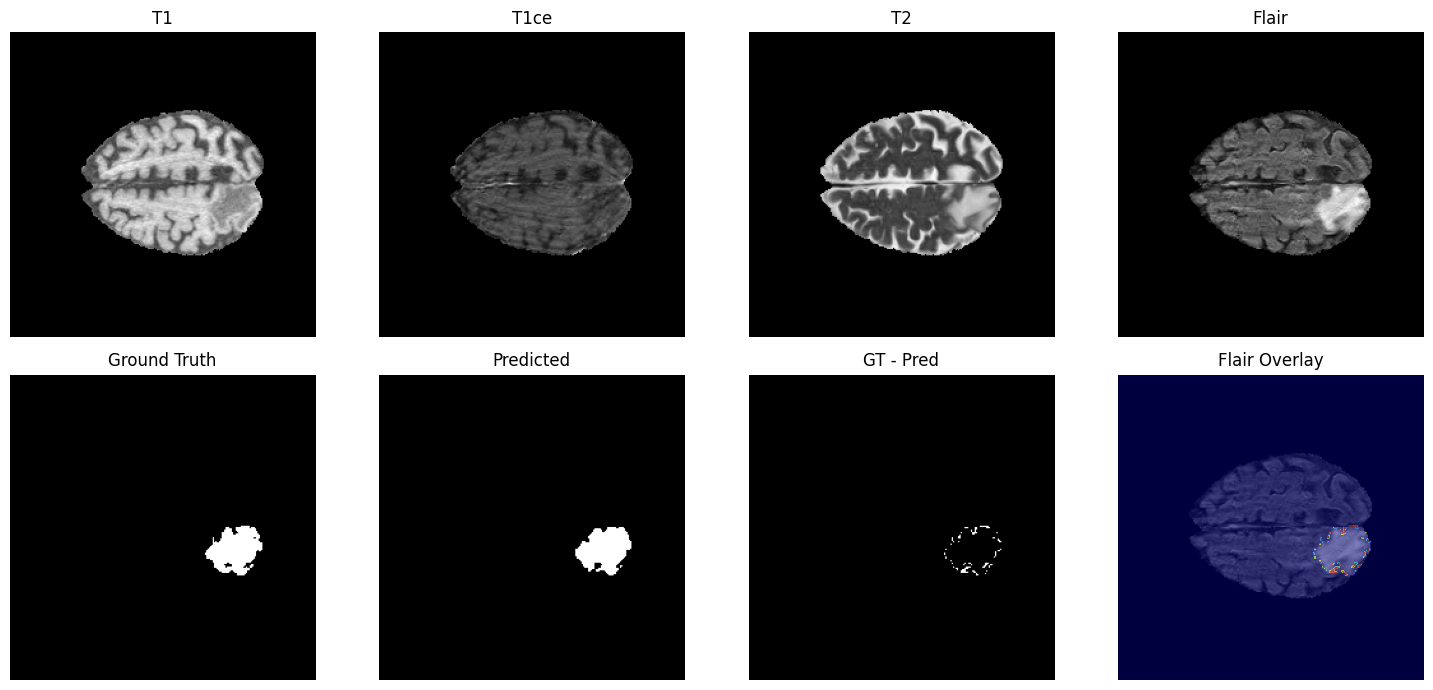

Example 2:
Mismatched labels: 119


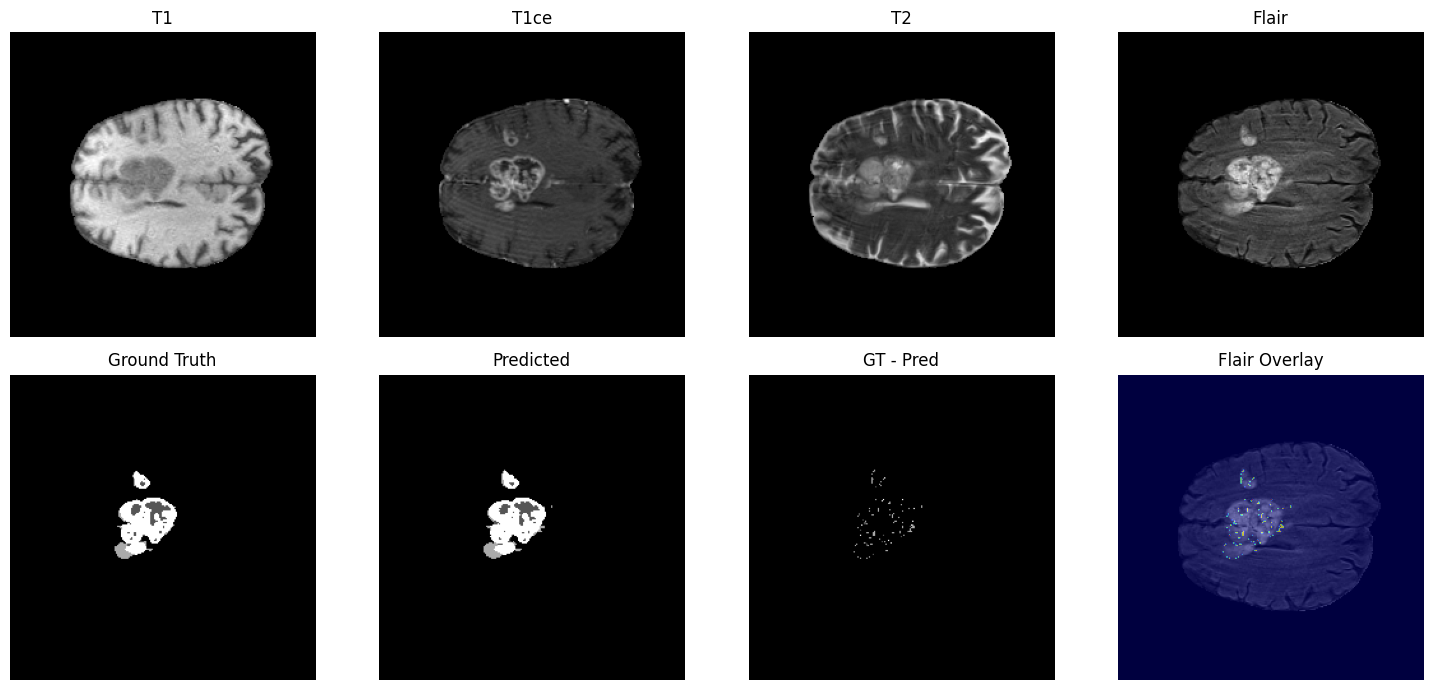

Example 3:
Mismatched labels: 206


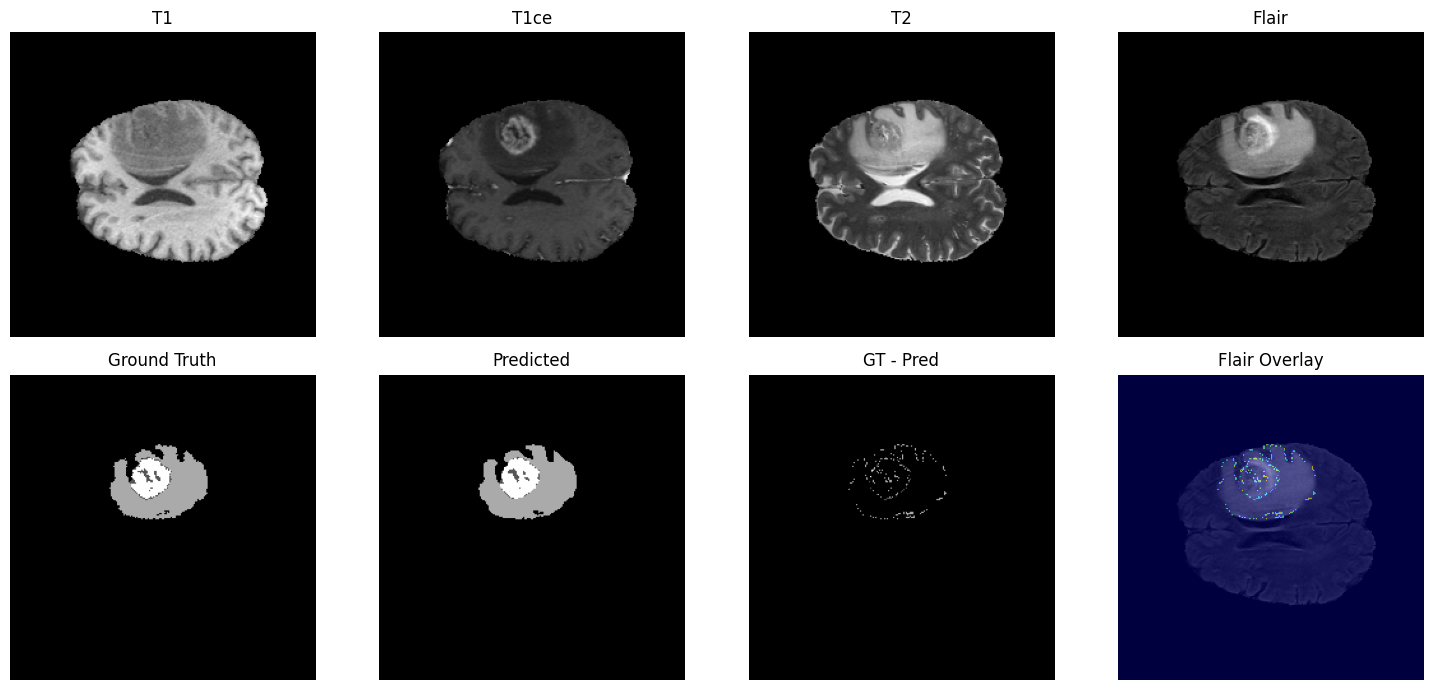

Example 4:
Mismatched labels: 37


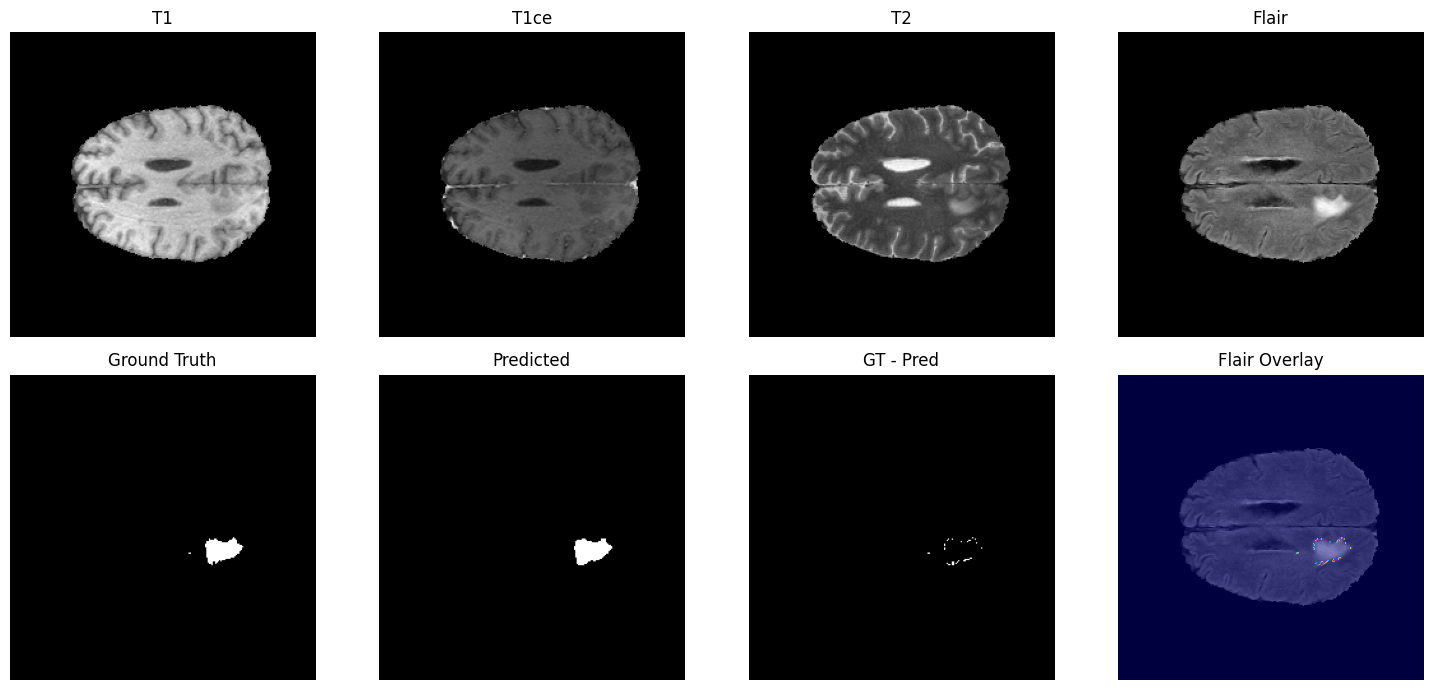

Example 5:
Mismatched labels: 174


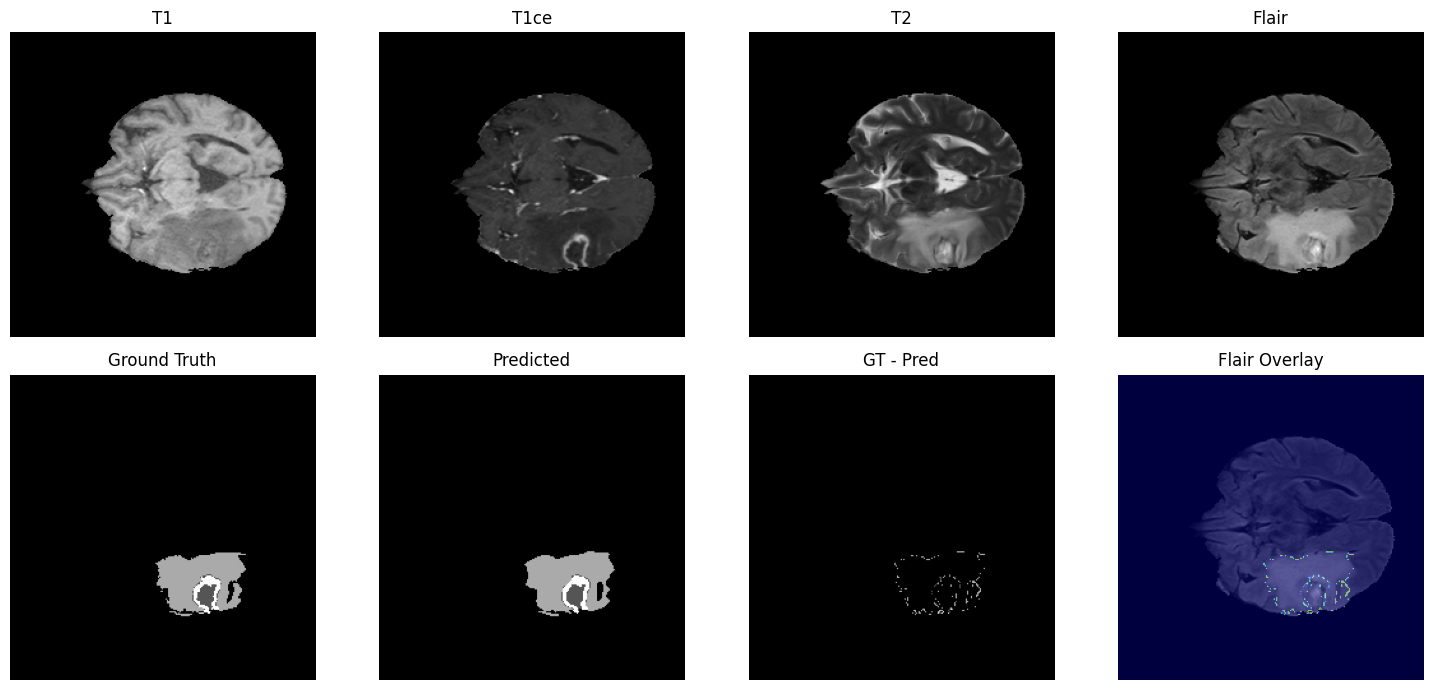

In [113]:
# Visualize the first 5 examples
for i in range(5):
    print(f"Example {i+1}:")
    visual_num(i)